# **Tutorial**: Using the simulators `wt.ModelA1`, `wt.ModelA2` and `wt.ModelB1`

[<<< Back to the simulator index](https://github.com/juangamella/causal-chamber-package/tree/main/causalchamber/simulators)

Other links:
- [Derivation of the simulators](https://arxiv.org/pdf/2404.11341#page=28&zoom=100,57,332)
- [Simulators source code](https://github.com/juangamella/causal-chamber-package/blob/main/causalchamber/simulators/wt/main.py)

If you use the simulators in your work, please consider citing:

```
﻿@article{gamella2025chamber,
  author={Gamella, Juan L. and Peters, Jonas and B{\"u}hlmann, Peter},
  title={Causal chambers as a real-world physical testbed for {AI} methodology},
  journal={Nature Machine Intelligence},
  doi={10.1038/s42256-024-00964-x},
  year={2025},
}
```

In [1]:
import sys
sys.path = ['../../..'] + sys.path

# %load_ext autoreload
# %autoreload 2

## Dependencies

Besides the `causalchamber` package, the notebook also uses `matplotlib`, `numpy` and `pandas` (specified in `tutorials/requirements.txt`).

In [2]:
import causalchamber
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import gridspec


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or simulators for your work please consider citing:

﻿@article{gamella2025chamber,
  author={Gamella, Juan L. and Peters, Jonas and B{"u}hlmann, Peter},
  title={Causal chambers as a real-world physical testbed for {AI} methodology},
  journal={Nature Machine Intelligence},
  doi={10.1038/s42256-024-00964-x},
  year={2025},
}



## Initializing the simulators

We take the simulator parameters from calibration experiments and the technical specifications of the fans. See [this notebook](https://github.com/juangamella/causal-chamber-paper/blob/main/case_studies/mechanistic_models.ipynb) for the complete process.

In [3]:
# For models A1 and B1
C_MIN = 0.166
C_MAX = 0.27
L_MIN = 0.1
OMEGA_MAX = 3000

# For model A2
I = 3.481e-05
T = 0.05
K = 5.268701549401565e-08 # This is called "C" in the notebook linked above

#   Torque function (also a parameter for model A2)
def tau(load, C_min=C_MIN, C_max=C_MAX, L_min=L_MIN, T=T):
    load = np.atleast_1d(load)
    torques = T * (C_min + np.maximum(L_min, load) ** 3 * (C_max - C_min) - C_min)
    torques[load == 0] = 0
    return torques if len(load) > 1 else torques[0]

Now we initialize the simulators with the above parameters:

In [4]:
import causalchamber.simulators.wt as wt

sim_a1 = wt.ModelA1(L_min = L_MIN,
                    omega_max = OMEGA_MAX)

sim_a2 = wt.ModelA2(I = I,
                    tau = tau,
                    K = K,
                    omega_0 = L_MIN * OMEGA_MAX) # We assume the initial velocity is the idle speed of the fans

sim_b1 = wt.ModelB1(C_min=C_MIN,
                    C_max=C_MAX,
                    L_min=L_MIN)

## Running the simulators

To simulate, call the function `.simulate_from_inputs` with a dataframe containing the simulator inputs as columns. There can be additional columns, which the simulator will ignore.

The names of the necessary columns can be obtained by calling:

In [5]:
sim_a1.inputs_names

['load']

In [6]:
sim_a2.inputs_names

['load', 'timestamp']

In [7]:
sim_b1.inputs_names

['load']

### Example 1: Random inputs

#### Model A1 and B1

We can use models A1 and B1 to simulate the steady-state fan speed and current (respectively). As inputs, let us take random fan loads from the valid range [0,1].

In [8]:
rng = np.random.default_rng(7); N = 100
inputs = pd.DataFrame({'load': rng.uniform(0,1,size=N)})

fan_speed = sim_a1.simulate_from_inputs(inputs)
fan_current = sim_b1.simulate_from_inputs(inputs)

Text(0.5, 0, 'Fan load')

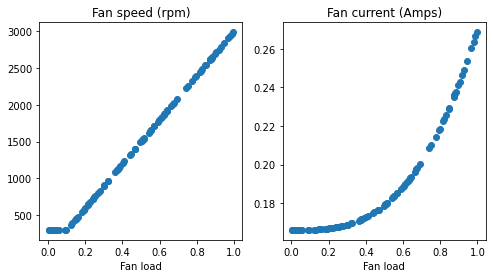

In [9]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(inputs.load, fan_speed)
plt.title("Fan speed (rpm)")
plt.xlabel("Fan load")

plt.subplot(1,2,2)
plt.scatter(inputs.load, fan_current)
plt.title("Fan current (Amps)")
plt.xlabel("Fan load")

#### Model A2

The simulator models the dynamics of the fan speed, given a time series of the load and the timestamps at which measurements happen.

To keep it simple, let us simulate what happens when we turn the load on (`load=1`) and off (`load=0`) in a short impulse, and take measurements every 0.1 seconds.

In [10]:
inputs = pd.DataFrame({'load': np.array([0] * 30 + [1] * 20 + [0] * 50), 'timestamp': np.linspace(0,10,100)})
fan_speed = sim_a2.simulate_from_inputs(inputs)

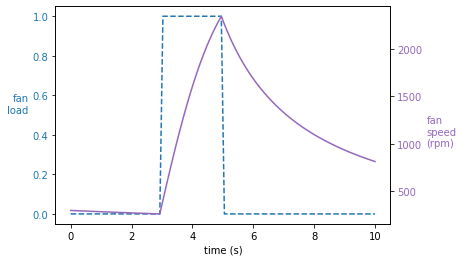

In [11]:
plt.figure()
ax1 = plt.gca()

c1,c2 = 'tab:blue', 'tab:purple'

ax1.set_xlabel('time (s)')
ax1.set_ylabel('fan\nload', color=c1, rotation=0, ha="right")
ax1.plot(inputs.timestamp, inputs.load, color=c1, linestyle='--')
ax1.tick_params(axis='y', labelcolor=c1)

ax2 = ax1.twinx()
ax2.set_ylabel('fan\nspeed\n(rpm)', color=c2, rotation=0, ha="left")
ax2.plot(inputs.timestamp, fan_speed, color=c2)
ax2.tick_params(axis='y', labelcolor=c2)

### Example 2: Comparing to real measurements

We download a dataset of real measurements using the functionality provided in the `causalchamber` package. The downloaded dataset is stored in the path given by `root=` below.

For our experiment we will use the `wt_test_v1` dataset, which is described [here](https://github.com/juangamella/causal-chamber/tree/main/datasets/wt_test_v1).

In [12]:
# Download the dataset
dataset = causalchamber.datasets.Dataset('wt_test_v1', root='./', download=True)

# Load the "steps" experiment
experiment = dataset.get_experiment(name='steps')
observations = experiment.as_pandas_dataframe().iloc[0:100]

Dataset wt_test_v1 found in "wt_test_v1".


We will compare our simulator with the behaviour of the intake fan in the above experiment.

First, let us create the inputs for all three simulator (we need `load` and `timestamp`). The simulators A1 and B1 will ignore the `timestamp` column.

In [13]:
inputs = pd.DataFrame({'load': observations.load_in,
                       'timestamp': observations.timestamp})

output_a1 = sim_a1.simulate_from_inputs(inputs)
output_b1 = sim_b1.simulate_from_inputs(inputs)
output_a2 = sim_a2.simulate_from_inputs(inputs)

**Plot the results**: real vs. simulated measurements of the fan speed and current

Text(0.5, 0, 'time (s)')

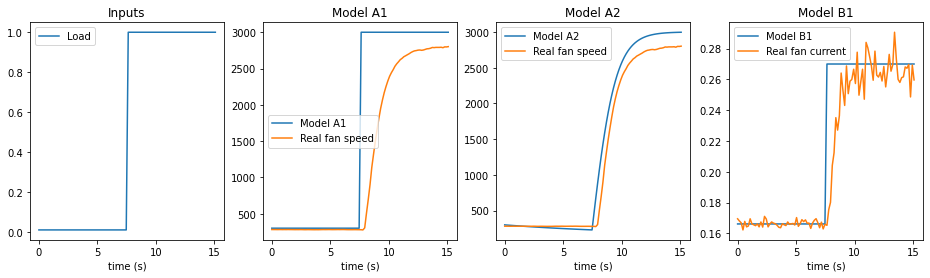

In [14]:
plt.figure(figsize=(16,4))

# x-axis is elapsed time since beginning of experiment
t = inputs.timestamp - inputs.timestamp.iloc[0]

# Plot 1: load
plt.subplot(141)
plt.title("Inputs")
plt.plot(t, inputs.load, label="Load")
plt.legend()
plt.xlabel("time (s)")

# Plot 2: Model A1 vs. fan speed
plt.subplot(142)
plt.title("Model A1")
plt.plot(t, output_a1, label="Model A1")
plt.plot(t, observations.rpm_in, label="Real fan speed")
plt.legend()
plt.xlabel("time (s)")

# Plot 3: Model A3 vs. fan speed
plt.subplot(143)
plt.title("Model A2")
plt.plot(t, output_a2, label="Model A2")
plt.plot(t, observations.rpm_in, label="Real fan speed")
plt.legend()
plt.xlabel("time (s)")

# Plot 4: Model B1 vs. fan current
plt.subplot(144)
# See Table I in Appendix II of [1] to see how the current in Amps is calculated
current_amps = observations.current_in / 1023 * 2.5 * 1.16 / 5 
plt.title("Model B1")
plt.plot(t, output_b1, label="Model B1")
plt.plot(t, current_amps, label="Real fan current")
plt.legend()
plt.xlabel("time (s)")